In [1]:
!pip install -U efficientnet

     |████████████████████████████████| 50 kB 4.8 MB/s 


In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau
from efficientnet.keras import EfficientNetB0

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import ReduceLROnPlateau


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [5]:
train = import_data('../input/digit-recognizer/train.csv')
test = import_data('../input/digit-recognizer/test.csv')

y_lab = train['label']
y = tf.keras.utils.to_categorical(y_lab) 
train.drop('label', axis=1, inplace=True)

Memory usage of dataframe is 251.54 MB
Memory usage after optimization is: 58.32 MB
Decreased by 76.8%
Memory usage of dataframe is 167.48 MB
Memory usage after optimization is: 38.59 MB
Decreased by 77.0%


In [6]:
train_df = np.array(train).reshape(-1, 28, 28, 1)
test_df = np.array(test).reshape(-1, 28, 28, 1)

del train
del test
del y_lab

In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def change_size(image):
    img = array_to_img(image, scale=False) 
    img = img.resize((75, 75))
    img = img.convert(mode='RGB')
    arr = img_to_array(img)
    return arr.astype(np.float32)

In [8]:
train_array = [change_size(img) for img in train_df]
train = np.array(train_array)
del train_array

test_array = [change_size(img) for img in test_df]
test = np.array(test_array)
del test_array

In [9]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rest of your code
image_gen = ImageDataGenerator(rescale=1./255,
                              featurewise_center=False,
                              preprocessing_function=get_random_eraser(v_l=0, v_h=1),
                              samplewise_center=False,
                              featurewise_std_normalization=False,
                              samplewise_std_normalization=False,
                              zca_whitening=False,
                              zoom_range=0.1,
                              rotation_range=10,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              shear_range=0.3,
                              validation_split=0.2) # 80/20 train/val split

train_generator = image_gen.flow(train, 
                                 y,
                                batch_size=32,
                                shuffle=True,
                                subset='training',
                                seed=42)
valid_generator = image_gen.flow(train,
                                 y,
                                batch_size=16,
                                shuffle=True,
                                subset='validation')

del train_df
del test_df
del train


In [11]:
model = Sequential()

model.add(tf.keras.applications.resnet50.ResNet50(input_shape = (75, 75, 3),
                                pooling = 'avg',
                                include_top = False, 
                                weights = 'imagenet'))

model.add(L.Flatten())
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(10, activation='softmax'))

model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), loss='categorical_crossentropy', metrics=['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


94773248/94765736 [==============================] - 3s 0us/step


In [12]:
for layer in model.layers[0].layers:
    if layer.name == 'conv5_block1_0_conv':
        break
    layer.trainable=False

In [13]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=5, 
          steps_per_epoch=train_generator.n//train_generator.batch_size,
         validation_steps=valid_generator.n//valid_generator.batch_size, 
          callbacks=[learning_rate_reduction])

Epoch 1/5
1050/1050 [==============================] - 106s 88ms/step - loss: 0.8193 - accuracy: 0.7679 - val_loss: 0.9243 - val_accuracy: 0.7840
Epoch 2/5
1050/1050 [==============================] - 92s 87ms/step - loss: 0.2685 - accuracy: 0.9259 - val_loss: 30.5537 - val_accuracy: 0.4269
Epoch 3/5
1050/1050 [==============================] - 92s 87ms/step - loss: 0.2190 - accuracy: 0.9422 - val_loss: 2.2131 - val_accuracy: 0.8893
Epoch 4/5
1050/1050 [==============================] - 94s 89ms/step - loss: 0.2028 - accuracy: 0.9474 - val_loss: 0.2831 - val_accuracy: 0.9294
Epoch 5/5
1050/1050 [==============================] - 95s 90ms/step - loss: 0.1821 - accuracy: 0.9535 - val_loss: 1.4428 - val_accuracy: 0.9227


In [14]:
test = test/255 

In [15]:
res = model.predict(test[:])
output = pd.DataFrame({'ImageId':[ i+1 for i in range(len(res))], 
                       'Label': [ xi.argmax() for xi in res]})
output.to_csv('submission_grid.csv', index=False)

predicted:  2


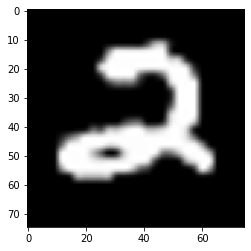

predicted:  0


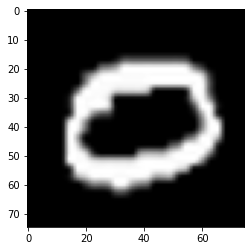

predicted:  9


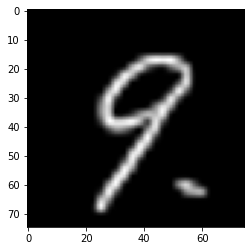

predicted:  0


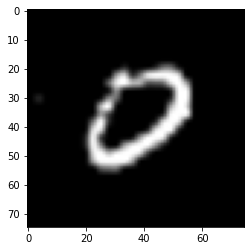

predicted:  3


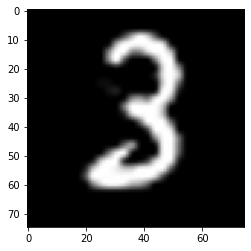

In [16]:
for i in range(5):
    print("predicted: ",res[i].argmax())
    plt.imshow(test[i],cmap="gray")
    plt.show()

In [17]:
#Now training model number 2, the effective net
IMG_SIZE = 75

modelEffLayer = EfficientNetB0(weights = 'imagenet', input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, pooling = 'max')
modelEff = Sequential()
modelEff.add(modelEffLayer)
modelEff.add(L.Flatten())
modelEff.add(L.Dense(128, activation='relu'))
modelEff.add(L.Dense(10, activation='softmax'))

modelEff.summary()



16809984/16804768 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 1280)              4049564   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               163968    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 4,214,822
Trainable params: 4,172,806
Non-trainable params: 42,016
_________________________________________________________________


In [18]:
modelEff.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0), loss='categorical_crossentropy', metrics=['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


In [19]:
historyEff = modelEff.fit(train_generator, validation_data=valid_generator, epochs=5, 
          steps_per_epoch=train_generator.n//train_generator.batch_size,
         validation_steps=valid_generator.n//valid_generator.batch_size, 
          callbacks=[learning_rate_reduction])

Epoch 1/5
1050/1050 [==============================] - 116s 99ms/step - loss: 0.7007 - accuracy: 0.8004 - val_loss: 0.2475 - val_accuracy: 0.9340
Epoch 2/5
1050/1050 [==============================] - 102s 97ms/step - loss: 0.2410 - accuracy: 0.9341 - val_loss: 0.1686 - val_accuracy: 0.9463
Epoch 3/5
1050/1050 [==============================] - 102s 97ms/step - loss: 0.1940 - accuracy: 0.9479 - val_loss: 0.2410 - val_accuracy: 0.9621
Epoch 4/5
1050/1050 [==============================] - 104s 99ms/step - loss: 0.1866 - accuracy: 0.9535 - val_loss: 0.1317 - val_accuracy: 0.9614
Epoch 5/5
1050/1050 [==============================] - 103s 98ms/step - loss: 0.2089 - accuracy: 0.9543 - val_loss: 1.0294 - val_accuracy: 0.9548


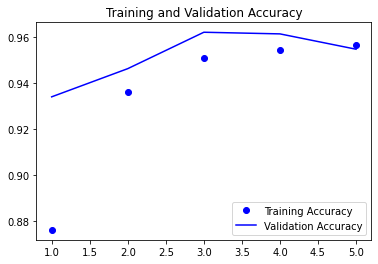

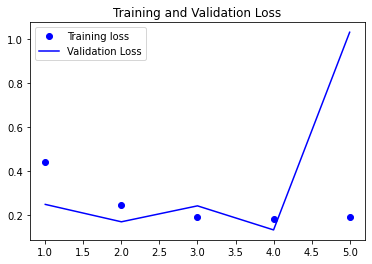

In [20]:
acc = historyEff.history['accuracy']
val_acc = historyEff.history['val_accuracy']
loss = historyEff.history['loss']
val_loss = historyEff.history['val_loss']

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

predicted:  2


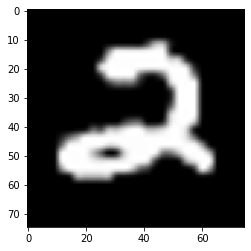

predicted:  0


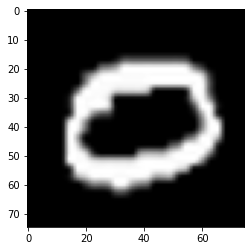

predicted:  9


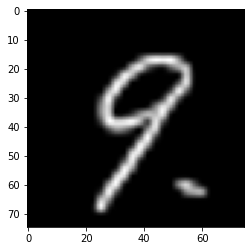

predicted:  0


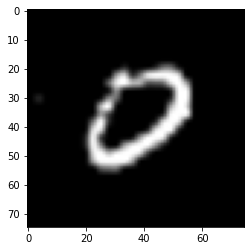

predicted:  3


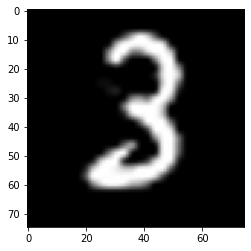

In [21]:
resEff = modelEff.predict(test[:])
outputEff = pd.DataFrame({'ImageId':[ i+1 for i in range(len(resEff))], 
                       'Label': [ xi.argmax() for xi in resEff]})
outputEff.to_csv('submission_grid_Eff.csv', index=False)
for i in range(5):
    print("predicted: ",resEff[i].argmax())
    plt.imshow(test[i],cmap="gray")
    plt.show()

In [22]:
#Now, We Have the History via the two models, we will now be creating a stacking ensemble
model.save('model1.h5')
modelEff.save('model2.h5')

In [23]:
members = list()
members.append(model)
members.append(modelEff)

In [24]:
from keras.layers import Input, Average
from keras.models import Model

model_inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
model_outputs = [model(model_inputs) for model in members]
ensembleOutputs = Average()(model_outputs)
modelEn = Model(inputs = model_inputs, outputs = ensembleOutputs)
modelEn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:
historyEn = modelEn.fit(train_generator, validation_data=valid_generator, epochs=5)

Epoch 1/5
1050/1050 [==============================] - 125s 108ms/step - loss: 0.1476 - accuracy: 0.9483 - val_loss: 0.2357 - val_accuracy: 0.8450
Epoch 2/5
1050/1050 [==============================] - 115s 109ms/step - loss: 0.2098 - accuracy: 0.8955 - val_loss: 0.2057 - val_accuracy: 0.8706
Epoch 3/5
1050/1050 [==============================] - 112s 107ms/step - loss: 0.2045 - accuracy: 0.8709 - val_loss: 0.2660 - val_accuracy: 0.8013
Epoch 4/5
1050/1050 [==============================] - 111s 106ms/step - loss: 0.2036 - accuracy: 0.8614 - val_loss: 0.1940 - val_accuracy: 0.8790
Epoch 5/5
1050/1050 [==============================] - 110s 105ms/step - loss: 0.1958 - accuracy: 0.8657 - val_loss: 0.1823 - val_accuracy: 0.8783


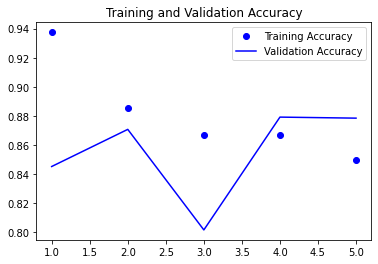

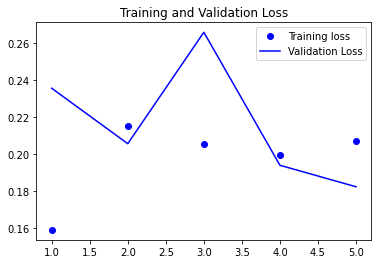

In [26]:
# print(historyEn.history)
acc = historyEn.history['accuracy']
val_acc = historyEn.history['val_accuracy']
loss = historyEn.history['loss']
val_loss = historyEn.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()